# Quantum teleportation

This notebook demonstrates quantum teleportation using dynamic circuits on IBM Quantum systems. This tutorial is based on the Qiskit Textbook's [section on Quantum Teleportation](https://qiskit.org/textbook/ch-algorithms/teleportation.html) and assumes that you have reviewed the material there. 

## Overview

Alice wants to send quantum information to Bob. Specifically, suppose they want to send the qubit state
$\vert\psi\rangle = \alpha\vert0\rangle + \beta\vert1\rangle$. 
This entails passing on information about $\alpha$ and $\beta$ to Bob.

The no-cloning theorem states that you cannot simply make an exact copy of an unknown quantum state. Therefore, Alice can't simply generate a copy of $\vert\psi\rangle$ and give the copy to Bob. We can only copy classical states (not superpositions).

However, by taking advantage of two classical bits and an entangled qubit pair, Alice can transfer their state $\vert\psi\rangle$ to Bob. We call this teleportation because, at the end, Bob will have $\vert\psi\rangle$ and Alice won't anymore.

To transfer a quantum bit, Alice and Bob must use a third party to send an entangled pair and then apply the Quantum Teleportation Protocol to "teleport" Alice's qubit to Bob. 

The Qiskit Textbook [Teleportation Section](https://qiskit.org/textbook/ch-algorithms/teleportation.html) provides more detail on the protocol, simulating the protocol and running on IBM hardware using deferred measurement. Here we will execute quantum teleportation on IBM hardware using dynamic circuits.

## The quantum teleportation protocol

To transfer a quantum bit, Alice and Bob must use a third party (Telamon) to send them an entangled qubit pair. Alice then performs some operations on their qubit and sends the results to Bob over a classical communication channel. Bob then performs some operations on their end to receive Alice’s qubit. 

In [1]:
# Do the necessary imports
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit import transpile
from qiskit.visualization import plot_histogram
from qiskit_ibm_provider import IBMProvider
from qiskit.circuit import IfElseOp

Create our quantum circuit:

In [2]:
## SETUP
# Protocol uses 3 qubits and 2 classical bits in 2 different registers
# Include a third register for measuring Bob's result
qr = QuantumRegister(3, name="q")
crz, crx = ClassicalRegister(1, name="crz"), ClassicalRegister(1, name="crx")
crb = ClassicalRegister(1, name="crb")
teleportation_circuit = QuantumCircuit(qr, crz, crx, crb)

#### Step 1

Use two qubits to create an entangled Bell pair. Qubit $a$ is given to Alice, qubit $b$ is given to Bob:

In [3]:
def create_bell_pair(qc, a, b):
    """Creates a bell pair in qc using qubits a & b"""
    qc.h(a)  # Put qubit a into state |+>
    qc.cx(a, b)  # CNOT with a as control and b as target

In [4]:
## STEP 1
create_bell_pair(teleportation_circuit, 1, 2)

Let's say Alice owns $q_1$ and Bob owns $q_2$ after they part ways.

#### Step 2 

Alice applies a CNOT gate to $q_1$, controlled by $\vert\psi\rangle$ (the qubit they are 
trying to send Bob). Then Alice applies a Hadamard gate to $\vert\psi\rangle$. In our quantum circuit, the qubit ($\vert\psi\rangle$) Alice is trying to send is $q_0$:

In [5]:
def alice_gates(qc, psi, a):
    qc.cx(psi, a)
    qc.h(psi)

In [6]:
## STEP 2
teleportation_circuit.barrier()  # Use barrier to separate steps
alice_gates(teleportation_circuit, 0, 1)

#### Step 3
Next, Alice applies a measurement to both qubits that they own,  $q_1$,  $\vert\psi\rangle$, and stores this result in two classical bits. They then send these two bits to Bob.

In [7]:
def measure_and_send(qc, a, b):
    """Measures qubits a & b and 'sends' the results to Bob"""
    qc.barrier()
    qc.measure(a, 0)
    qc.measure(b, 1)

In [8]:
measure_and_send(teleportation_circuit, 0, 1)

#### Step 4

Bob, who already has the qubit $q_2$, then applies the following gates depending on the state of the classical bits:

00 $\rightarrow$ Do nothing

01 $\rightarrow$ Apply $X$ gate

10 $\rightarrow$ Apply $Z$ gate

11 $\rightarrow$ Apply $ZX$ gate

(*Note that this transfer of information is purely classical*.)

In [9]:
# This function takes a QuantumCircuit (qc), integer (qubit)
# and ClassicalRegisters (crz & crx) to decide which gates to apply
def bob_gates(qc, qubit, crz, crx):
    # Here we use qc.if_test to control our gates with a classical
    # bit instead of a qubit
    with qc.if_test((crx, 1)):
        qc.x(qubit)
    with qc.if_test((crz, 1)):
        qc.z(qubit)

In [10]:
## STEP 4
teleportation_circuit.barrier()  # Use barrier to separate steps
bob_gates(teleportation_circuit, 2, crz, crx)

#### Step 5

Finally, Bob measures their qubit to verify the teleportation of Alice's qubit state.

In [11]:
## STEP 5
crb = ClassicalRegister(1, name="crb")
teleportation_circuit.measure(2, 2)

### Full quantum teleportation circuit

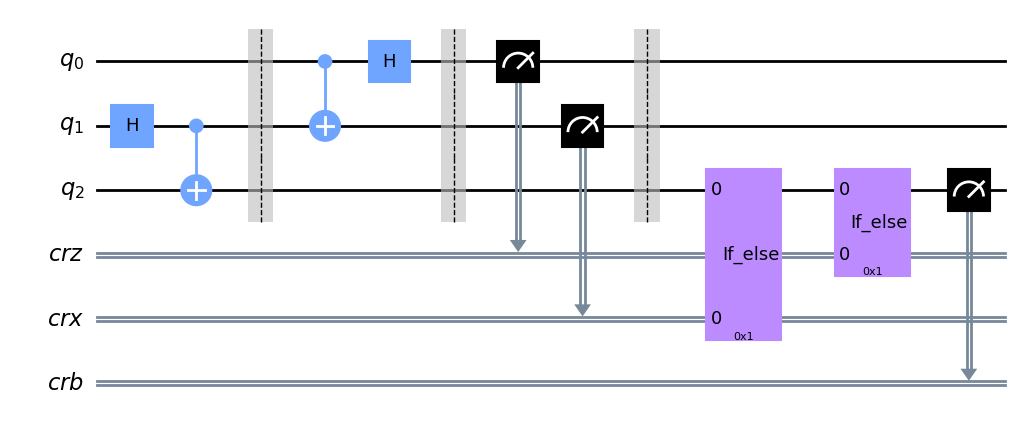

In [12]:
## SETUP
# Protocol uses 3 qubits and 2 classical bits in 2 different registers
# include third register for measuring Bob's result
qr = QuantumRegister(3, name="q")
crz, crx = ClassicalRegister(1, name="crz"), ClassicalRegister(1, name="crx")
crb = ClassicalRegister(1, name="crb")
teleportation_circuit = QuantumCircuit(qr, crz, crx, crb)

## STEP 1
create_bell_pair(teleportation_circuit, 1, 2)

## STEP 2
teleportation_circuit.barrier()  # Use barrier to separate steps
alice_gates(teleportation_circuit, 0, 1)

## STEP 3
measure_and_send(teleportation_circuit, 0, 1)

## STEP 4
teleportation_circuit.barrier()  # Use barrier to separate steps
bob_gates(teleportation_circuit, 2, crz, crx)

## STEP 5
crb = ClassicalRegister(1, name="crb")
teleportation_circuit.measure(2, 2)
teleportation_circuit.draw(
    "mpl", cregbundle=False
)  # suppress RuntimeWarning with cregbundle=False

## Execute using dynamic circuits on IBM hardware

With the introduction of the dynamic circuits feature, IBM Quantum computers support the [qiskit.circuit.QuantumCircuit.if_test](https://qiskit.org/documentation/stubs/qiskit.circuit.QuantumCircuit.if_test.html). We will now execute the quantum teleportation circuit on an IBM Quantum computer. 

In [13]:
from qiskit_ibm_provider import least_busy
from qiskit.tools.monitor import job_monitor

In [14]:
# define backend to request
# Note: This can be any hub/group/project that has access to the required device and Qiskit Runtime.
hub = "<hub>"
group = "<group>"
project = "<project>"
backend_name = "<your backend>"
hgp = f"{hub}/{group}/{project}"

In [15]:
# load backend
provider = IBMProvider()
backend = provider.get_backend(backend_name, instance=hgp)

# backend = least_busy(provider.backends(dynamic_circuits=True))
print(f"Using backend {backend.name}")

### Teleport the ground state

In [16]:
# transpile our circuit for the selected backend
# backend.target.add_instruction(IfElseOp, name="if_else")
transpiled_circuit = transpile(teleportation_circuit, backend)

In [17]:
# run job
shots = 1000
job = backend.run(transpiled_circuit, shots=shots, dynamic=True)

In [18]:
print(f"Job ID: {job.job_id()}")
job_monitor(job)  # displays job status under cell

Job ID: cgdmlmmv33msamgmc9g0
Job Status: job has successfully run


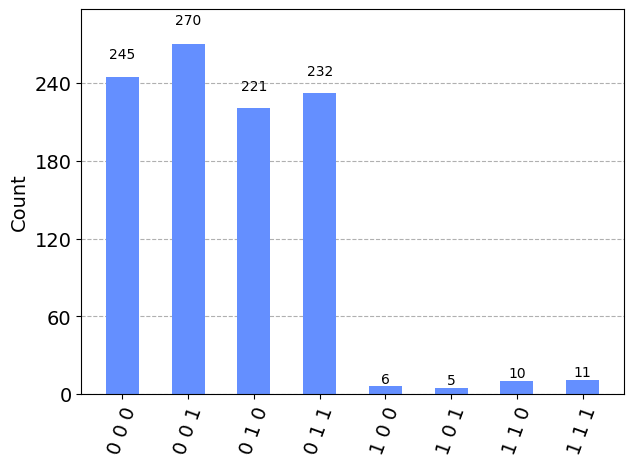

In [19]:
# Get the results and display them
exp_result = job.result()
exp_counts = exp_result.get_counts()
plot_histogram(exp_counts)

The results returned from our job have keys with the most recent measurement in the most significant bit. These are in the form of 'crb, crx, crz' where crb is Bob's measurement. To get Bob's results, we need to trace out the results from the crx and crz measurements by summing all the results when Bob measured $\vert0\rangle$, and compare with the results when Bob measured $\vert1\rangle$. We may use the `marginal_counts` method from `qiskit.result` to get Bob's results.

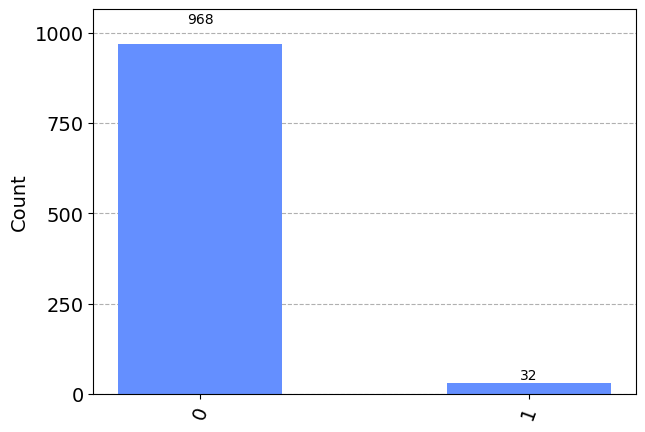

In [20]:
# trace out Bob's results on qubit 2
from qiskit.result import marginal_counts

bobs_qubit = 2
bobs_counts = marginal_counts(exp_counts, [bobs_qubit])
plot_histogram(bobs_counts)

In this experiment, the quantum teleportation protocol executed correctly if we measure the $\vert0\rangle$ state with a probability approaching 1. There are a few results in which we measured $\vert1\rangle$. These arise due to errors in the gates and qubits. In contrast, the simulator used in [Simulating The Teleporation Protocol](https://qiskit.org/textbook/ch-algorithms/teleportation.html#3.-Simulating-the-Teleportation-Protocol-) had zero errors in its gates, and allowed error-free teleportation. 

In [21]:
print(
    f"The experimental error rate : {bobs_counts['1']*100/sum(bobs_counts.values()):.3f}%"
)

The experimental error rate : 3.200%


This experimental error rate is driven by the physical properties of the qubits and the gate error rates. In this case we have teleported the ground state. The measurement expectation of Bob's qubit will naturally be biased towards the ground state due to decoherence, resulting in an artificially low error rate. To fully characterize the state, see [Quantum State Tomography](https://qiskit.org/documentation/experiments/tutorials/state_tomography.html), and for the process, see [Quantum Process Tomography](https://qiskit.org/documentation/experiments/stubs/qiskit_experiments.library.tomography.ProcessTomography.html#qiskit_experiments.library.tomography.ProcessTomography). 

### Teleport the excited state

We will now place Alice's qubit in the excited state prior to running the protocol. In this case we should now measure $\vert1\rangle$ with a probability approaching 1.

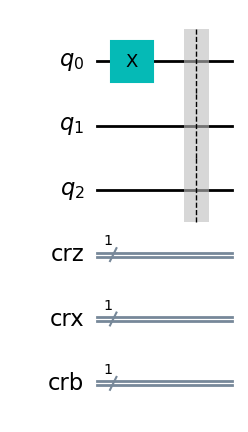

In [22]:
# create an circuit with an excited qubit with the same structure as our teleportation circuit
qr2 = QuantumRegister(3, name="q")
crz2, crx2 = ClassicalRegister(1, name="crz"), ClassicalRegister(1, name="crx")
crb2 = ClassicalRegister(1, name="crb")
excite_circuit = QuantumCircuit(qr2, crz2, crx2, crb2)
excite_circuit.x(0)
excite_circuit.barrier()
excite_circuit.draw(output="mpl")

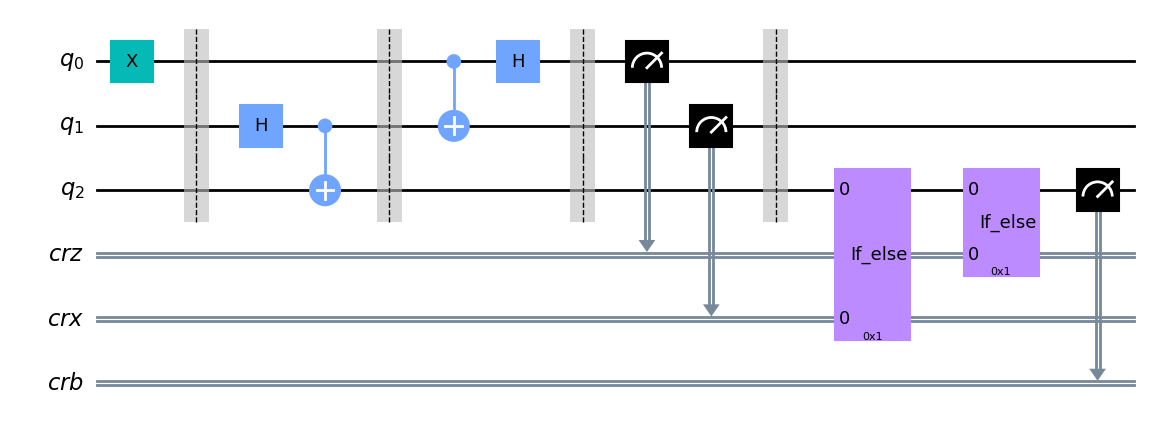

In [23]:
teleport_excited_circuit = excite_circuit.compose(teleportation_circuit)
teleport_excited_circuit.draw(
    output="mpl", cregbundle=False
)  # suppress RuntimeWarning with cregbundle=False

In [24]:
# transpile, run and plot results
transpiled_circuit = transpile(teleport_excited_circuit, backend)
# run job
shots = 1000
job = backend.run(transpiled_circuit, shots=shots, dynamic=True)
print(f"Job ID: {job.job_id()}")
job_monitor(job)  # displays job status under cell

Job ID: cgdmlpai9pt33qip0tn0
Job Status: job has successfully run


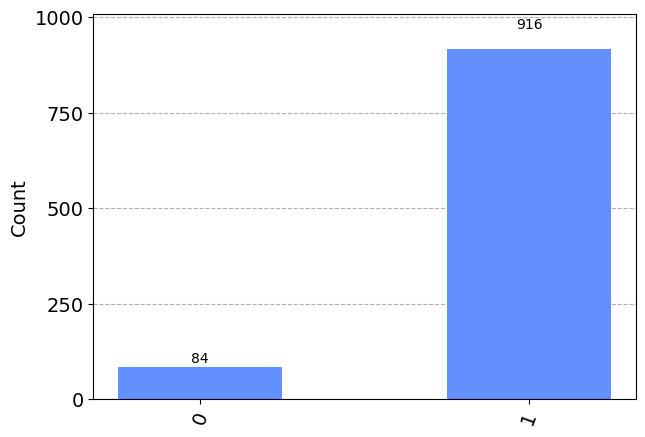

In [25]:
exp_result = job.result()
exp_counts = exp_result.get_counts()
bobs_counts = marginal_counts(exp_counts, [bobs_qubit])
plot_histogram(bobs_counts)

As we can see here, we are now measuring the expected excited state $\vert1\rangle$.

In [26]:
print(
    f"The experimental error rate : {bobs_counts['0']*100/sum(bobs_counts.values()):.3f}%"
)

The experimental error rate : 8.400%


### Teleport a superposition state

Finally, we put Alice's qubit into a superposition using a Hadamard gate. In this case Bob should measure $\vert0\rangle$ and $\vert1\rangle$ each with 50% probability.

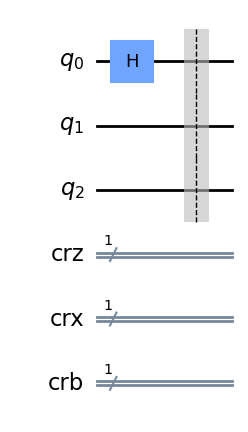

In [27]:
# create an circuit with an qubit in a superposition with the same structure as our teleportation circuit
qr3 = QuantumRegister(3, name="q")
crz3, crx3 = ClassicalRegister(1, name="crz"), ClassicalRegister(1, name="crx")
crb3 = ClassicalRegister(1, name="crb")
superposition_circuit = QuantumCircuit(qr3, crz3, crx3, crb3)
superposition_circuit.h(0)
superposition_circuit.barrier()
superposition_circuit.draw(output="mpl")

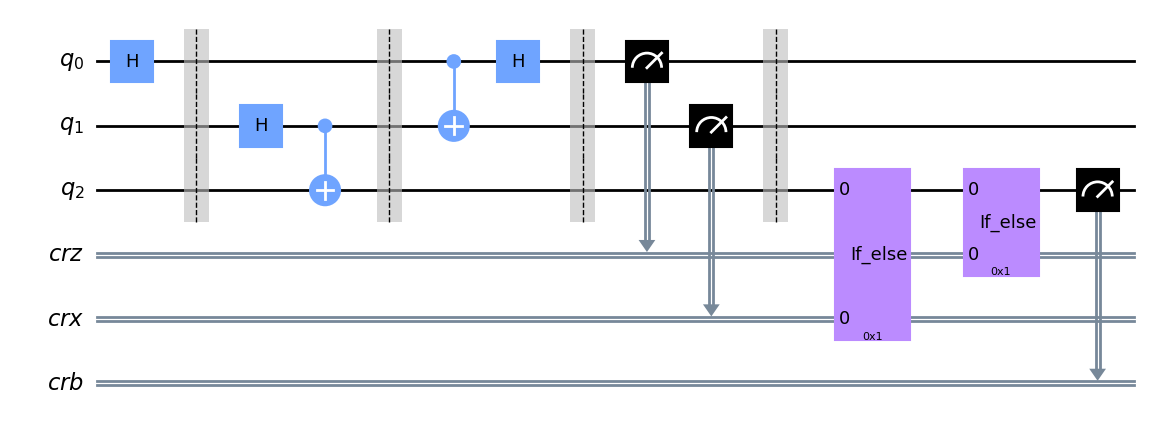

In [28]:
# add teleportation circuit
teleport_superposition_circuit = superposition_circuit.compose(teleportation_circuit)
teleport_superposition_circuit.draw(
    output="mpl", cregbundle=False
)  # suppress RuntimeWarning with cregbundle=False

In [29]:
# transpile, run and plot results
transpiled_circuit = transpile(teleport_superposition_circuit, backend)
# run job
shots = 1000
job = backend.run(transpiled_circuit, shots=shots, dynamic=True)
print(f"Job ID: {job.job_id()}")
job_monitor(job)  # displays job status under cell

Job ID: cgdmltmv33msamgmcifg
Job Status: job has successfully run


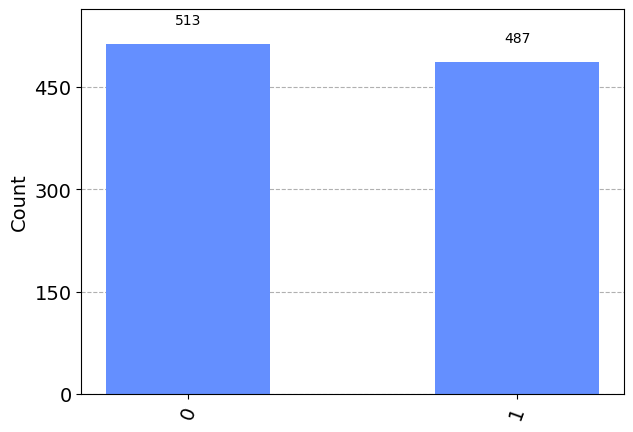

In [30]:
exp_result = job.result()
exp_counts = exp_result.get_counts()
bobs_counts = marginal_counts(exp_counts, [bobs_qubit])
plot_histogram(bobs_counts)

As expected, we find the probabilities approaching 50% for each state.

In [31]:
print(
    f"The experimental error rate : {abs(bobs_counts['0']*100/sum(bobs_counts.values())-50):.3f}%"
)

The experimental error rate : 1.300%


## References <a id='references'></a>

[1] M. Nielsen and I. Chuang, Quantum Computation and Quantum Information, Cambridge Series on Information and the Natural Sciences (Cambridge University Press, Cambridge, 2000).

[2] Eleanor Rieffel and Wolfgang Polak, Quantum Computing: a Gentle Introduction (The MIT Press Cambridge England, Massachusetts, 2011).

---

In [ ]:
import qiskit.tools.jupyter

%qiskit_version_table